In [0]:
#For Google Collab
from google.colab import drive, auth
from googleapiclient.discovery import build
#For data manipulation
import numpy as np 
import pandas as pd 
import random
#For Plotting
import matplotlib.pyplot as plt
#For Modeling
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Input, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers, regularizers
from keras.optimizers import Adam, SGD

In [9]:
# Load the Drive helper and mount
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
auth.authenticate_user()

In [0]:
drive_service = build('drive', 'v3')

In [0]:
#Create variable for image and batch size along with number of epochs committing to for model
height = 224
width = 224
batch_size = 32

train = ImageDataGenerator(rescale = 1/.255,rotation_range=30,horizontal_flip=True)
test = ImageDataGenerator(rescale=1/.255,rotation_range=30,horizontal_flip=True)

In [13]:
#Seting up train, test, and val sets for model

train_set = train.flow_from_directory('../content/drive/My Drive/Chest_X_rays/All_Chest/train'
                                      ,target_size=(width,height), 
                                      batch_size=batch_size,
                                      class_mode='categorical',              
                                     seed = 122)
test_set = train.flow_from_directory('../content/drive/My Drive/Chest_X_rays/All_Chest/test'
                                      ,target_size=(width,height), 
                                      batch_size=batch_size,
                                      class_mode='categorical',                              
                                    seed = 122)
val_set = train.flow_from_directory('../content/drive/My Drive/Chest_X_rays/All_Chest/val'
                                      ,target_size=(width,height), 
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                    seed = 122)

Found 4747 images belonging to 3 classes.
Found 1885 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


High accuracy and high overfitting.

In [0]:
inputs = Input(shape=(height, width, 3))
def inception3(inputs):
  tower_one = MaxPooling2D((1,1), strides=(1,1), padding='same')(inputs)
  tower_one = Conv2D(32, (1,1),kernel_regularizer=regularizers.l2(0.1), activation='relu', padding='same')(tower_one)

  tower_two = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
  tower_two = Conv2D(32, (3,3), activation='relu', padding='same')(tower_two)
  tower_two = Dropout(0.1)(tower_two)
  
  tower_three = BatchNormalization()(inputs)
  tower_three = Conv2D(32, (3,3),kernel_regularizer=regularizers.l2(0.1), activation='relu', padding='same')(tower_three)

  tower_four = Conv2D(32, (5,5), activation='relu', padding='same')(inputs)
  tower_four = Conv2D(32, (5,5), activation='relu', padding='same')(tower_four)
  tower_four = Dropout(.1)(tower_four)
  
  tower_five = BatchNormalization()(inputs)
  tower_five = Conv2D(32, (5,5), activation='relu', padding='same')(tower_five)
  
  x = concatenate([tower_one, tower_two, tower_three, tower_four, tower_five], axis=3)

  return x

In [22]:
def model3(train_set):
  x = inception3(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = inception3(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Dropout(.1)(x)
  x = inception3(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  predictions = Dense(3, activation='softmax')(x)

  model = Model(input=inputs, output=predictions)
  return model

modelC = model3(train_set)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [23]:
modelC.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 224, 224, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
modelC.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=Adam(lr=0.00001),
                 metrics=['accuracy'])
history = modelC.fit_generator(train_set, steps_per_epoch=25, epochs=10, validation_steps=50, verbose=1, validation_data=test_set)
history

Epoch 1/10
25/25 [==============================] - 90s 4s/step - loss: 22.8970 - acc: 0.7762 - val_loss: 22.7022 - val_acc: 0.8203
Epoch 2/10
25/25 [==============================] - 76s 3s/step - loss: 22.4504 - acc: 0.9088 - val_loss: 22.4983 - val_acc: 0.8606
Epoch 3/10
25/25 [==============================] - 76s 3s/step - loss: 22.2734 - acc: 0.9187 - val_loss: 22.3162 - val_acc: 0.8835
Epoch 4/10
25/25 [==============================] - 73s 3s/step - loss: 22.1164 - acc: 0.9300 - val_loss: 22.1886 - val_acc: 0.8791
Epoch 5/10
25/25 [==============================] - 74s 3s/step - loss: 21.9962 - acc: 0.9425 - val_loss: 22.1287 - val_acc: 0.8466
Epoch 6/10
25/25 [==============================] - 76s 3s/step - loss: 21.8175 - acc: 0.9412 - val_loss: 21.9003 - val_acc: 0.8892
Epoch 7/10
25/25 [==============================] - 77s 3s/step - loss: 21.6838 - acc: 0.9475 - val_loss: 21.7345 - val_acc: 0.8998
Epoch 8/10
25/25 [==============================] - 77s 3s/step - loss: 21.5

high accuracy and less overfitting.

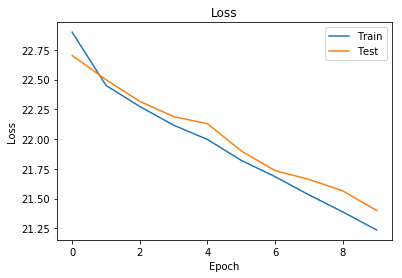

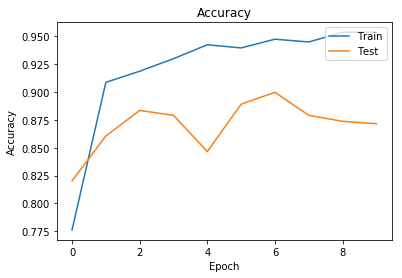

In [0]:
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Test')
plt.legend(loc = 'upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label = 'Train')
plt.plot(history.history['val_acc'], label = 'Test')
plt.legend(loc = 'upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.show()